In [1]:
%load_ext autoreload
%autoreload 1
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = [14, 10]

import torch
from torch.utils.data import Dataset
from retinanet.encoder import DataEncoder
import imgaug as ia
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
from retinanet.retinanet import RetinaNet
from retinanet.loss import FocalLoss
from pikachu_dataset import load_data_pikachu
from torch import nn
from torch.utils.data import Dataset
device  = 'cuda' if torch.cuda.is_available() else 'cpu'


/home/i008/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:

class PikachuDataset(Dataset):
    def __init__(self, anchor_areas=None):
        
        self.anchor_areas = anchor_areas
        self.train, self.val = load_data_pikachu(1)
        if anchor_areas is not None:
            encoder = DataEncoder(anchor_areas=anchor_areas)
        else:
            encoder = DataEncoder()            
        self.encoder = encoder 
        
    def __len__(self):
        return 900
        
    def __getitem__(self, i):
        try:
            b = self.train.next()
        except StopIteration:
            self.train.reset()
            b = self.train.next()
            
        image = b.data[0].asnumpy()
        bbox = b.label[0].asnumpy()[:, 0, 1:] * 256
        label = b.label[0].asnumpy()[:, 0, 0]
    
        return torch.from_numpy(image), torch.from_numpy(bbox), torch.from_numpy(label)    
    
    def collate_func(self, batch):
    

        images = [b[0][0] for b in batch]
        bbox = [b[1] for b in batch]
        labels = [b[2] for b in batch]
        
        encoded = [self.encoder.encode(bb, l, torch.Tensor([256, 256])) for bb, l in zip(bbox, labels)]
        loc_target = [l[0] for l in encoded]
        cls_target = [l[1] for l in encoded]
        

        return torch.stack(images) / 255, torch.stack(loc_target), torch.stack(cls_target)
        
        
def down_sample(in_channels,out_channels):
    return nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ReLU(),
                 nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ReLU(),
                  nn.MaxPool2d(2,2)
                 
                 )

class SimpleSSD(nn.Module):
    
    
    def __init__(self, n_cls=1, num_anchors=9):
        super(SimpleSSD, self).__init__()
        
        self.n_cls = n_cls
        self.num_anchors = num_anchors
        
        
        # Base CNN (think resnet/vgg or other base network)
        self.step1 = down_sample(3, 128)
        self.step2 = down_sample(128, 128)
        
        self.step3 = down_sample(128, 128)
        self.step4 = down_sample(128, 128)
        self.step5 = down_sample(128, 128)

        self.cls_head1 = nn.Conv2d(128, self.num_anchors * self.n_cls , 3, padding=1)
        self.bbox_head1 = nn.Conv2d(128, self.num_anchors *4, 3, padding=1)
        
        self.cls_head2 = nn.Conv2d(128, self.num_anchors * self.n_cls , 3, padding=1)
        self.bbox_head2 = nn.Conv2d(128,self.num_anchors * 4,3, padding=1)
        
        self.cls_head3 = nn.Conv2d(128, self.num_anchors * self.n_cls , 3, padding=1)
        self.bbox_head3 = nn.Conv2d(128, self.num_anchors * 4,3, padding=1)
        
        
    def forward(self, x):
        
        step1=self.step1(x)
        step2=self.step2(step1)

        step3=self.step3(step2)
        step4 = self.step4(step3)
        step5 = self.step5(step4)
        
        import pdb
        pdb.set_trace()
        
    
        cls1 = self.cls_head1(step3)
        bbox1 = self.bbox_head1(step3)
        
        cls2 = self.cls_head2(step4)
        bbox2 = self.bbox_head2(step4)
        
        cls3 = self.cls_head3(step5)
        bbox3 = self.bbox_head3(step5) 
        
    
        cls1 = cls1.permute(0,2,3,1).contiguous().view(x.size(0), -1, self.n_cls)
        cls2 = cls2.permute(0,2,3,1).contiguous().view(x.size(0), -1, self.n_cls)
        cls3 = cls3.permute(0,2,3,1).contiguous().view(x.size(0), -1, self.n_cls)
        
        bbox1 = bbox1.permute(0,2,3,1).contiguous().view(x.size(0), -1, 4)
        bbox2 = bbox2.permute(0,2,3,1).contiguous().view(x.size(0), -1, 4)
        bbox3 = bbox3.permute(0,2,3,1).contiguous().view(x.size(0), -1, 4)
      
        cls_pred = torch.cat([cls1, cls2, cls3], dim=1)
        bbox_pred = torch.cat([bbox1, bbox2, bbox3], dim=1)
        
        return bbox_pred, cls_pred
                

    

In [7]:
pikachu_ds =PikachuDataset(anchor_areas=[30*30, 50*50, 90*90])


In [8]:
pikachu_ds =PikachuDataset(anchor_areas=[30*30, 50*50, 90*90])
pikachu_dl = DataLoader(pikachu_ds, batch_size=2, collate_fn=pikachu_ds.collate_func)



# for b in pikachu_dl:
#     image, bounding_boxes, labels = b


# pikachu_ds[0]

In [9]:
model= SimpleSSD(1)
model = model.to(device)
criterion = FocalLoss(num_classes=1)

In [10]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
collect = []
for epoch in range(10):
    print(epoch)
    for b in pikachu_dl:
        optimizer.zero_grad()
        image, bounding_boxes, labels = b
        image = image.to(device)
        bounding_boxes = bounding_boxes.to(device)
        labels = labels.to(device)
        loc_pred, cls_pred = model(image)
        total_loss = criterion(loc_pred, bounding_boxes, cls_pred, labels)
        total_loss.backward()
        optimizer.step()
#         print(total_loss)
        collect.append([total_loss.detach().cpu().numpy()])


0
> <ipython-input-6-ac6b44705f5c>(96)forward()
-> cls1 = self.cls_head1(step3)
(Pdb) step5
tensor([[[[0.1881, 0.0532, 0.2480,  ..., 0.1282, 0.1276, 0.1900],
          [0.1570, 0.0807, 0.2609,  ..., 0.1088, 0.0000, 0.2438],
          [0.1465, 0.1371, 0.0490,  ..., 0.0669, 0.0635, 0.2608],
          ...,
          [0.0000, 0.1404, 0.1955,  ..., 0.0309, 0.1384, 0.1649],
          [0.0620, 0.0000, 0.1973,  ..., 0.1182, 0.0575, 0.2393],
          [0.0468, 0.0465, 0.1170,  ..., 0.0050, 0.0124, 0.2072]],

         [[0.5666, 1.0084, 1.2821,  ..., 1.1309, 0.8101, 1.2904],
          [0.1894, 0.3785, 0.8832,  ..., 0.7701, 0.3199, 0.6105],
          [0.3439, 0.7939, 0.5739,  ..., 0.6110, 0.2181, 0.6182],
          ...,
          [0.4715, 0.5599, 0.9422,  ..., 1.4151, 0.4168, 1.0787],
          [0.3066, 0.6054, 0.9222,  ..., 0.2502, 0.7734, 0.9060],
          [0.6666, 0.4600, 0.5754,  ..., 0.5951, 0.6048, 0.4415]],

         [[1.3395, 1.4747, 1.4536,  ..., 0.7314, 0.8824, 1.1494],
          [0.312

BdbQuit: 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efed00602b0>],
      dtype=object)

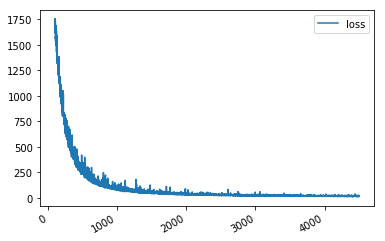

In [6]:
import pandas as pd
pd.DataFrame(collect, columns=['loss']).astype(float)[100:].plot(subplots=True)

# Visualize

failed in nnms


Text(0.5,1,'score tensor([0.6124], grad_fn=<IndexBackward>)')

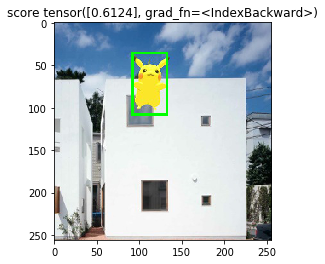

In [8]:
i = 1
bbspred, labelpred, score  = pikachu_ds.encoder.decode(
    loc_pred[i].float().cpu(), 
    cls_pred[i].float().cpu(), 
    torch.Tensor([256, 256]).float().cpu()
)

image_to_show = np.moveaxis(
    image[i].detach().cpu().numpy(),0, 2)

matched_anchors_on_image = ia.BoundingBoxesOnImage(
    [ia.BoundingBox(*b) for b in bbspred.detach().cpu().numpy()], shape=(256, 256))

image_to_show = matched_anchors_on_image.draw_on_image(image_to_show, thickness=3)
plt.imshow(image_to_show)
plt.title('score ' + str(score))

### Exercises

-  Load a custom image with pikachu( or many ) and try to make predictiosn with the network and visualize the result
-  Can you think of anything that could confuse our detector? yellow dots ?
- Currently the code is not really modular, try to make it nice by splitting it into logical parts
    - Base feature extractor Module
    - Head Creator module
- Currently the detection/cls HEADS are very simple (just one CONV layer) they can be more complex. Try using more convolutions, check other architectures how its done

- Can you use our network to train using some new data for instance:
    - https://www.kaggle.com/tomluther/ships-in-google-earth
    - https://www.kaggle.com/aruchomu/data-for-yolo-v3-kernel
    - https://www.kaggle.com/dataturks/face-detection-in-images
    - https://www.kaggle.com/dataturks/face-dataset-with-age-emotion-ethnicity  
 You will need to create a data loader/data sets similar as we did for the pikachu loader. 
